## ExMAS
> Equilibrium matching


In [1]:
import os
import math
import netwulf as nw
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching
from ExMAS.extras import games, pricings, prunings, pipeline

In [4]:
netwulf_config_path = os.path.join(os.getcwd(),'spinoff/game/netwulf_config.json')

In [5]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/ams.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
params.max_detour = 120  # windows
params.max_delay = 120  # windows
params.nP = 100
params.simTime = 0.25
params.shared_discount = 0.25
inData = ExMAS.utils.generate_demand(inData, params)  # generate requests

In [6]:
inData = ExMAS.main(inData, params, plot = False)

In [8]:
KPIs = inData.sblts.res.to_frame('u_pax')
inData = games.prepare_PoA(inData)  # prepare data structures

05-02-21 11:12:00-WARNING-Prepare for game:  1/6
05-02-21 11:12:00-WARNING-Prepare for game:  2/6
05-02-21 11:12:00-WARNING-Prepare for game:  3/6
05-02-21 11:12:01-WARNING-Prepare for game:  4/6
05-02-21 11:12:09-WARNING-Prepare for game:  5/6
05-02-21 11:12:09-WARNING-Prepare for game:  6/6


### pricing

eq. 1 , eq.2

In [8]:

params.time_cost = params.VoT # travellers' cost per travel time
params.wait_cost = params.time_cost*1.5 # and waiting
params.sharing_penalty_fixed = 0 # fixed penalty (EUR) per 
params.sharing_penalty_multiplier = 0 # fixed penalty (EUR) per 

params.veh_cost = 1.3*params.VoT/params.avg_speed # operating costs per kilometer
params.fixed_ride_cost = 0.5 # ride fixed costs (per vehicle)

In [9]:
inData.results.rides = inData.sblts.rides.copy()  # copy tables to collect results
inData.results.rm = inData.sblts.rides_multi_index.copy()
inData.results.KPIs = dict()

In [10]:
inData = games.prepare_PoA(inData)
inData = ExMAS.extras.pricings.update_costs(inData, params)
inData = pricings.externality_split(inData) 
inData = pricings.uniform_split(inData) 
inData = pricings.externality_split(inData) 
inData = pricings.residual_split(inData) 
inData = pricings.subgroup_split_bas(inData) 

04-02-21 14:24:34-WARNING-Prepare for game:  1/6
04-02-21 14:24:34-WARNING-Prepare for game:  2/6
04-02-21 14:24:34-WARNING-Prepare for game:  3/6
04-02-21 14:24:35-WARNING-Prepare for game:  4/6
04-02-21 14:24:43-WARNING-Prepare for game:  5/6
04-02-21 14:24:43-WARNING-Prepare for game:  6/6


In [11]:
ALGOS=dict() # algorithms to apply and their names
ALGOS['TNE'] = prunings.algo_TNE
ALGOS['HERMETIC'] = prunings.algo_HERMETIC
ALGOS['RUE'] = prunings.algo_RUE
ALGOS['RSIE'] = prunings.algo_RSIE
#ALGOS['TSE'] = prunings.algo_TSE

In [12]:
for ALGO, algorithm in ALGOS.items():
    print(ALGO)
    inData = algorithm(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy

TNE
HERMETIC
RUE
RSIE
04-02-21 14:25:00-WARNING-Searching unstable pairs 0/449. 0 found so far
04-02-21 14:25:13-WARNING-Searching unstable pairs 20/449. 328 found so far
04-02-21 14:25:27-WARNING-Searching unstable pairs 40/449. 716 found so far
04-02-21 14:25:40-WARNING-Searching unstable pairs 60/449. 923 found so far
04-02-21 14:25:55-WARNING-Searching unstable pairs 80/449. 1061 found so far
04-02-21 14:26:09-WARNING-Searching unstable pairs 100/449. 1123 found so far
04-02-21 14:26:20-WARNING-Searching unstable pairs 120/449. 1127 found so far
04-02-21 14:26:30-WARNING-Searching unstable pairs 140/449. 1133 found so far
04-02-21 14:26:42-WARNING-Searching unstable pairs 160/449. 1133 found so far
04-02-21 14:26:53-WARNING-Searching unstable pairs 180/449. 1144 found so far
04-02-21 14:27:03-WARNING-Searching unstable pairs 200/449. 1165 found so far
04-02-21 14:27:15-WARNING-Searching unstable pairs 220/449. 1190 found so far
04-02-21 14:27:25-WARNING-Searching unstable pairs 240

In [13]:
for ALGO, algorithm in ALGOS.items():  # perform assignment for single prunings
    inData = pipeline.single_eval(inData, params,
                         MATCHING_OBJS = ['total_group_cost'],  # this can be more
                         PRUNINGS = [ALGO],  # and this can be more
                         PRICING = 'UNIFORM',  # this is taken from first level loop
                         minmax = ('min','max'))  # direction BPoA, WPoA

04-02-21 14:29:17-WARNING-Prunings:  ['TNE']
04-02-21 14:29:17-WARNING-Pruned nRides 149/449
04-02-21 14:29:17-WARNING-Mutually exclusives 0
04-02-21 14:29:17-WARNING-Scenario-many_Pricing-UNIFORM_Objective-['total_group_cost']_Pruning-['TNE']_minmax-min
04-02-21 14:29:18-WARNING-Scenario-many_Pricing-UNIFORM_Objective-['total_group_cost']_Pruning-['TNE']_minmax-max
04-02-21 14:29:19-WARNING-Prunings:  ['HERMETIC']
04-02-21 14:29:19-WARNING-Pruned nRides 132/449
04-02-21 14:29:19-WARNING-Mutually exclusives 0
04-02-21 14:29:19-WARNING-Scenario-many_Pricing-UNIFORM_Objective-['total_group_cost']_Pruning-['HERMETIC']_minmax-min
04-02-21 14:29:20-WARNING-Scenario-many_Pricing-UNIFORM_Objective-['total_group_cost']_Pruning-['HERMETIC']_minmax-max
04-02-21 14:29:20-WARNING-Prunings:  ['RUE']
04-02-21 14:29:20-WARNING-Pruned nRides 449/449
04-02-21 14:29:20-WARNING-Mutually exclusives 74
04-02-21 14:29:20-WARNING-Scenario-many_Pricing-UNIFORM_Objective-['total_group_cost']_Pruning-['RUE']_mi

In [40]:
rm = inData.sblts.rides_multi_index
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    rm['best_{}'.format(PRICING)]=rm.apply(lambda r: rm[rm.traveller == r.traveller].cost_user.min(),axis = 1)

In [1]:
rm.columns

NameError: name 'rm' is not defined

In [14]:
#inData = pipeline.single_eval_windows(inData, params, None, 'EXMAS', 'WINDOWS')

TNE


KeyError: "UNIFORM-['total_group_cost']-['TNE']-total_group_cost-min"

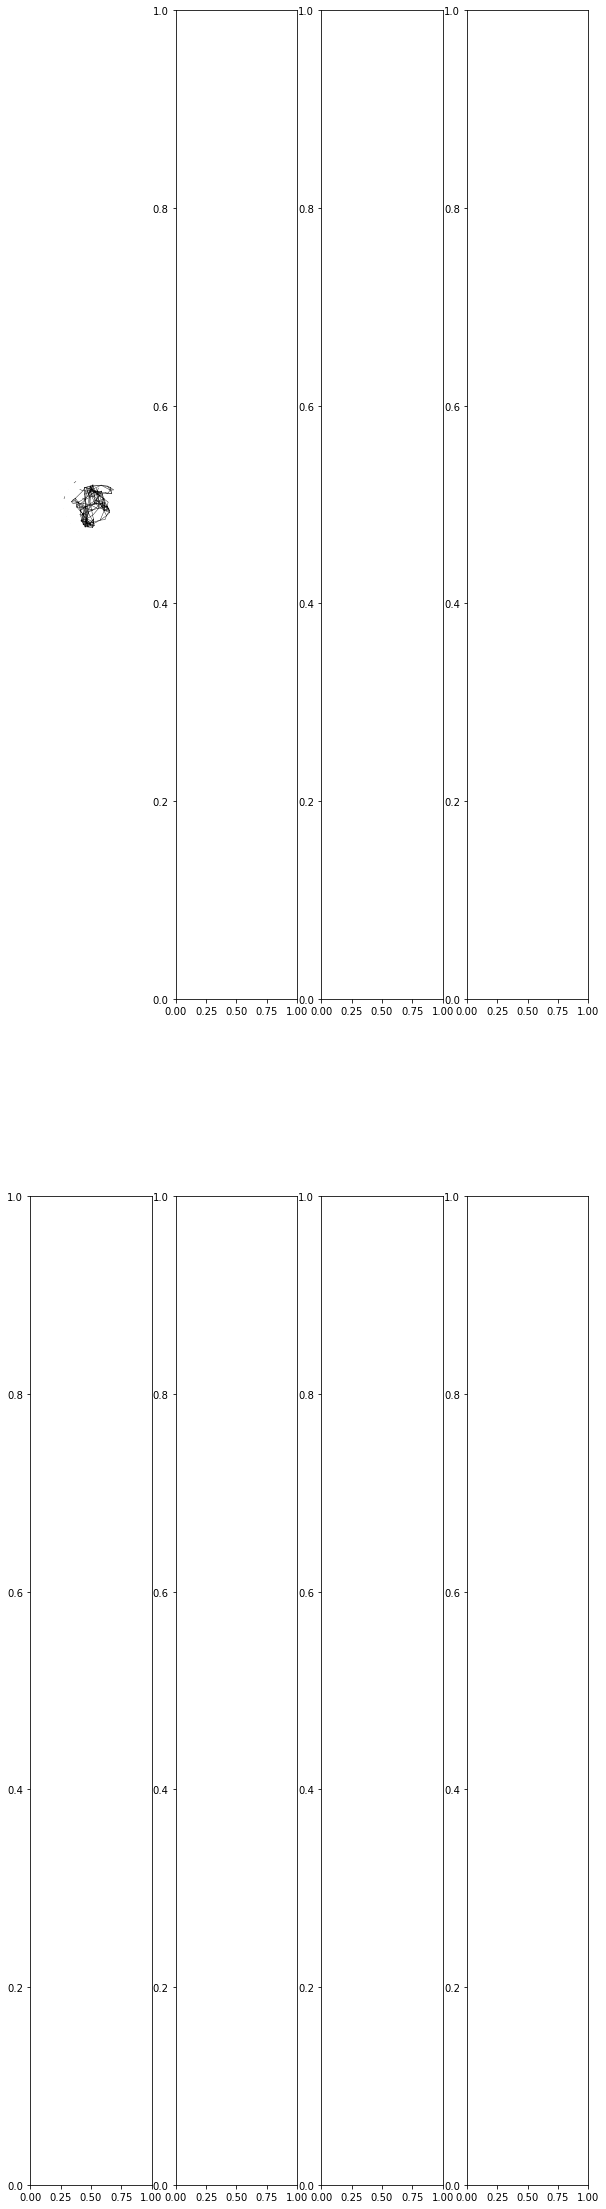

In [15]:
r = inData.results.rides
_, config, _ = nw.load("netwulf_config.json") # load config
_, config_schedule, _ = nw.load("netwulf_config_schedule.json") # load config
fig, axes = plt.subplots(2,4, figsize = (10,40))
i=0
for ALGO, algorithm in ALGOS.items():  # perform assignment for single prunings
    print(ALGO)
    if "pruned_{}".format(ALGO) in r.columns:
        this_rides = r[r["pruned_{}".format(ALGO)]==True]
    else:
        this_rides = r
    G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, this_rides)
    f, _ = nw.visualize(G, config = config_schedule,  plot_in_cell_below=False)
    _, _ = nw.draw_netwulf(f, fig = fig, ax = axes[0][i])
    this_schedule = r[r["UNIFORM-['total_group_cost']-['{}']-total_group_cost-min".format(ALGO)]==True]
    G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, this_schedule)
    f, _ = nw.visualize(G, config = config_schedule,  plot_in_cell_below=False)
    _, _ = nw.draw_netwulf(f, fig = fig, ax = axes[1][i])
    i+=1
    

### ExMAS 


two graphs for each algorithm: 
* first shareability potential groups
* then assignment, ILP solution for BPoA

nodes are travellers, links if they form a group, size is the degree (number of rides in which you may participate)

In [ ]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.schedule)
stylized_network, config_schedule = nw.visualize(G, config = config_schedule)  # create config
#nw.save("netwulf_config_schedule.json", stylized_network, config_schedule) # save config
#_, _ = nw.visualize(G, config = config_schedule)

### TNE 


In [ ]:
params.multi_platform_matching = True
params.assign_ride_platforms = False
inData = prunings.algo_TNE(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy
inData = pipeline.single_eval(inData, params,
                     MATCHING_OBJS = ['UNIFORM'],  # this can be more
                     PRUNINGS = ['TNE'],  # and this can be more
                     PRICING = 'UNIFORM',  # this is taken from first level loop
                     minmax = ['min'], store_res = False)  # direction BPoA, WPoA
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.rides[inData.sblts.rides.pruned])
_, _ = nw.visualize(G, config = config)

In [ ]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.schedule)
_, _ = nw.visualize(G, config = config_schedule)

In [ ]:
params.multi_platform_matching = True
params.assign_ride_platforms = False
inData = prunings.algo_HERMETIC(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy
inData = pipeline.single_eval(inData, params,
                     MATCHING_OBJS = ['UNIFORM'],  # this can be more
                     PRUNINGS = ['HERMETIC'],  # and this can be more
                     PRICING = 'UNIFORM',  # this is taken from first level loop
                     minmax = ['min'], store_res = False)  # direction BPoA, WPoA
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.rides[inData.sblts.rides.pruned])
_, _ = nw.visualize(G, config = config)

In [ ]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.schedule)
_, _ = nw.visualize(G, config = config_schedule)

---
(c) Rafał Kucharski, Delft, 2020